2025-03-04 17:55:59.790558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 17:55:59.790681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 17:55:59.920120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Processing images: 100%|██████████| 17717/17717 [07:45<00:00, 38.10it/s]


Number of images per class:
Infiltration: 9547
Atelectasis: 4215
Effusion: 3955
Found 14174 images belonging to 3 classes.
Found 3543 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 14174
Number of validation samples: 3543
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/443 ━━━━━━━━━━━━━━━━━━━━ 11:34:27 94s/step - accuracy: 0.3125 - loss: 1.1342

I0000 00:00:1741111536.616119      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


443/443 ━━━━━━━━━━━━━━━━━━━━ 405s 702ms/step - accuracy: 0.4259 - loss: 1.1006 - val_accuracy: 0.2258 - val_loss: 1.2298
Epoch 2/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 240s 534ms/step - accuracy: 0.5244 - loss: 0.9948 - val_accuracy: 0.5456 - val_loss: 0.9586
Epoch 3/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 238s 531ms/step - accuracy: 0.5486 - loss: 0.9529 - val_accuracy: 0.5868 - val_loss: 0.9083
Epoch 4/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 239s 534ms/step - accuracy: 0.5819 - loss: 0.9069 - val_accuracy: 0.6049 - val_loss: 0.8834
Epoch 5/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 238s 530ms/step - accuracy: 0.6053 - loss: 0.8838 - val_accuracy: 0.6198 - val_loss: 0.8542
Epoch 6/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 238s 530ms/step - accuracy: 0.6175 - loss: 0.8594 - val_accuracy: 0.6252 - val_loss: 0.8429
Epoch 7/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 243s 541ms/step - accuracy: 0.6253 - loss: 0.8382 - val_accuracy: 0.6252 - val_loss: 0.8325
Epoch 8/25
443/443 ━━━━━━━━━━━━━━━━━━━━ 233s 520ms/step - accuracy: 0.6231 - loss: 0.83

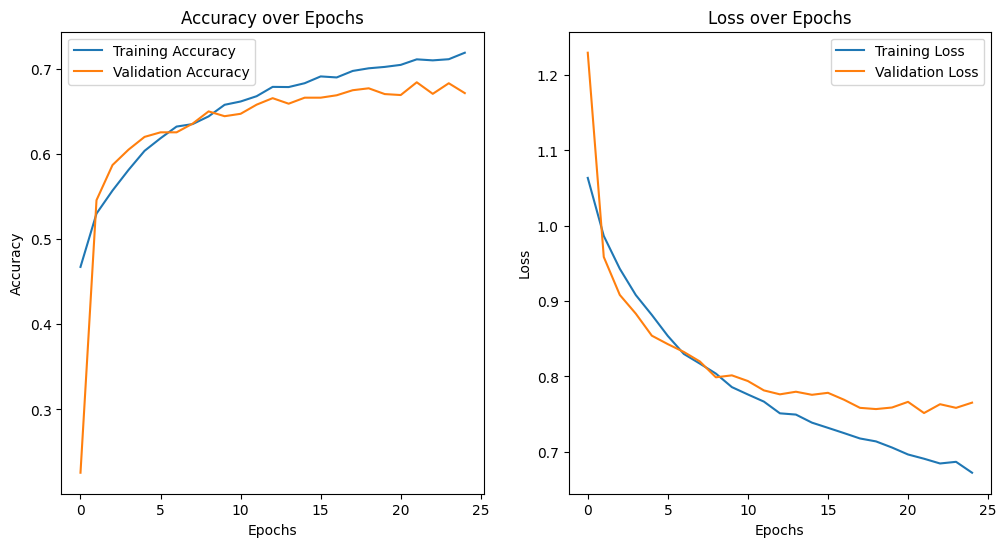

In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set paths
data_entry_path = "/kaggle/input/data/Data_Entry_2017.csv"
weights_path = "/kaggle/input/efficientnet/tensorflow2/default/1/efficientnetb0_notop (1).h5"

# Load the data entry file
data_entry = pd.read_csv(data_entry_path)

# Specify the diseases
selected_diseases = ['Infiltration', 'Atelectasis', 'Effusion']
data_entry = data_entry[data_entry['Finding Labels'].apply(lambda x: x in selected_diseases)]
data_entry['label'] = data_entry['Finding Labels']

# List of image folder paths
image_paths = [
    '/kaggle/input/data/images_001/images',
    '/kaggle/input/data/images_002/images',
    '/kaggle/input/data/images_003/images',
    '/kaggle/input/data/images_004/images',
    '/kaggle/input/data/images_005/images',
    '/kaggle/input/data/images_006/images',
    '/kaggle/input/data/images_007/images',
    '/kaggle/input/data/images_008/images',
    '/kaggle/input/data/images_009/images',
    '/kaggle/input/data/images_010/images',
    '/kaggle/input/data/images_011/images',
    '/kaggle/input/data/images_012/images',
]

# Collect all image paths
all_image_paths = []
for path in image_paths:
    all_image_paths.extend(glob.glob(f"{path}/*.png"))

# Map image names to their full paths
image_path_dict = {os.path.basename(image): image for image in all_image_paths}

# Add the image path to the DataFrame
data_entry['path'] = data_entry['Image Index'].map(image_path_dict.get)
data_entry = data_entry.dropna(subset=['path'])  # Remove rows where no matching image was found

# Preprocess images
def preprocess_image(image_path, target_size=(256, 256)):
    try:
        image = cv2.imread(image_path)
        if image is None or len(image.shape) != 3 or image.shape[2] != 3:
            return None
        image = cv2.resize(image, target_size)
        image = image / 255.0
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Prepare directory for processed images
filtered_image_dir = "processed_images"
os.makedirs(filtered_image_dir, exist_ok=True)

# Dictionary to keep track of the image count for each class
class_counts = {disease: 0 for disease in selected_diseases}

# Process and save all images, and count them
for _, row in tqdm(data_entry.iterrows(), desc="Processing images", total=data_entry.shape[0]):
    path = row['path']
    label = row['label']
    preprocessed_image = preprocess_image(path)
    if preprocessed_image is not None:
        class_dir = os.path.join(filtered_image_dir, label)
        os.makedirs(class_dir, exist_ok=True)  # Create subdirectory for each class
        image_name = os.path.basename(path)
        save_path = os.path.join(class_dir, image_name)
        cv2.imwrite(save_path, (preprocessed_image * 255).astype(np.uint8))
        
        # Increment the count for the class
        class_counts[label] += 1

# Print the number of images in each class
print("Number of images per class:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

# Data generators with augmentation for training and validation
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)

# Build and compile the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights=weights_path, input_shape=(256, 256, 3))
for layer in base_model.layers[-90:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(selected_diseases), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=25, validation_data=val_generator)

# Save the trained model
model.save("lung_disease_model.h5")

# Evaluate model performance
val_preds = np.argmax(model.predict(val_generator), axis=-1)
val_labels = val_generator.labels

precision = precision_score(val_labels, val_preds, average=None)
recall = recall_score(val_labels, val_preds, average=None)
f1 = f1_score(val_labels, val_preds, average=None)

for i, disease in enumerate(selected_diseases):
    print(f"Precision for {disease}: {precision[i] * 100:.2f}%")
    print(f"Recall for {disease}: {recall[i] * 100:.2f}%")
    print(f"F1 Score for {disease}: {f1[i] * 100:.2f}%")

overall_precision = precision_score(val_labels, val_preds, average='macro')
overall_recall = recall_score(val_labels, val_preds, average='macro')
overall_f1 = f1_score(val_labels, val_preds, average='macro')

print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1 * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Found 14174 images belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


443/443 ━━━━━━━━━━━━━━━━━━━━ 185s 418ms/step


Copying high-confidence images: 100%|██████████| 9268/9268 [00:02<00:00, 3245.73it/s]


Found 7415 images belonging to 3 classes.
Found 1853 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 7415
Number of validation samples: 1853
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


232/232 ━━━━━━━━━━━━━━━━━━━━ 182s 773ms/step - accuracy: 0.8911 - loss: 0.3426 - val_accuracy: 0.9271 - val_loss: 0.2302
Epoch 2/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 124s 522ms/step - accuracy: 0.9192 - loss: 0.2361 - val_accuracy: 0.9385 - val_loss: 0.1791
Epoch 3/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 124s 521ms/step - accuracy: 0.9246 - loss: 0.2148 - val_accuracy: 0.9379 - val_loss: 0.1811
Epoch 4/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 124s 523ms/step - accuracy: 0.9241 - loss: 0.2081 - val_accuracy: 0.9315 - val_loss: 0.1709
Epoch 5/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 123s 519ms/step - accuracy: 0.9339 - loss: 0.1783 - val_accuracy: 0.9423 - val_loss: 0.1600
Epoch 6/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 124s 520ms/step - accuracy: 0.9317 - loss: 0.1791 - val_accuracy: 0.9304 - val_loss: 0.1766
Epoch 7/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 123s 519ms/step - accuracy: 0.9395 - loss: 0.1692 - val_accuracy: 0.9390 - val_loss: 0.1514
Epoch 8/25
232/232 ━━━━━━━━━━━━━━━━━━━━ 124s 521ms/step - accuracy: 0.9432 - loss: 0.15

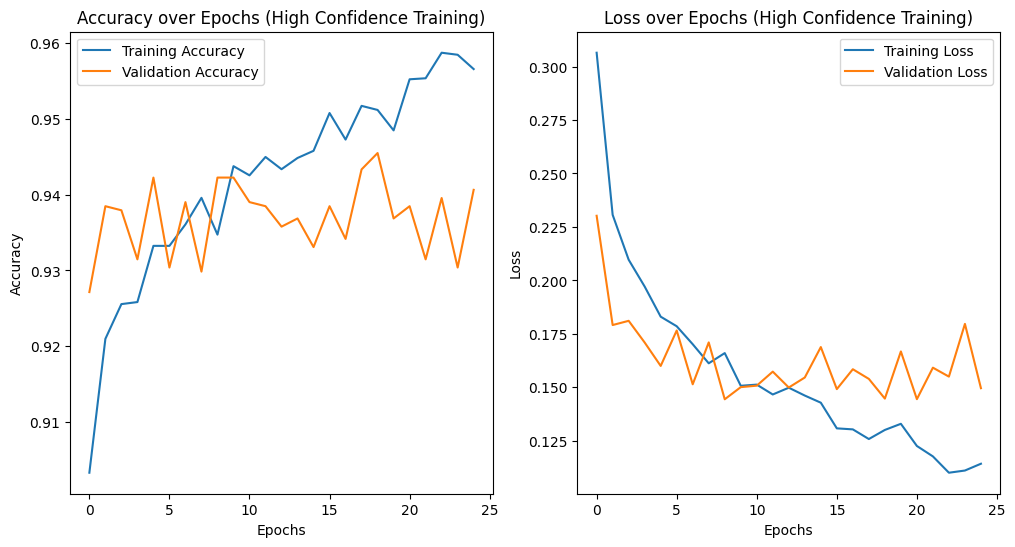

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select the top 3800 high-confidence images per class
selected_images = []
for disease in selected_diseases:
    disease_images = train_data[train_data['predicted_class'] == disease]
    top_images = disease_images.nlargest(3800, 'confidence')  # Select top 3800 by confidence
    selected_images.append(top_images)

selected_images = pd.concat(selected_images)

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Evaluate model and calculate metrics
val_predictions = model.predict(high_confidence_val_generator)
val_predicted_labels = val_predictions.argmax(axis=1)
true_labels = high_confidence_val_generator.classes

# Per-class metrics
precision = precision_score(true_labels, val_predicted_labels, average=None)
recall = recall_score(true_labels, val_predicted_labels, average=None)
f1 = f1_score(true_labels, val_predicted_labels, average=None)

for i, disease in enumerate(selected_diseases):
    print(f"Precision for {disease}: {precision[i] * 100:.2f}%")
    print(f"Recall for {disease}: {recall[i] * 100:.2f}%")
    print(f"F1 Score for {disease}: {f1[i] * 100:.2f}%")

# Overall metrics
overall_precision = precision_score(true_labels, val_predicted_labels, average='macro')
overall_recall = recall_score(true_labels, val_predicted_labels, average='macro')
overall_f1 = f1_score(true_labels, val_predicted_labels, average='macro')

print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1 * 100:.2f}%")

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Found 14174 images belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


443/443 ━━━━━━━━━━━━━━━━━━━━ 183s 413ms/step


Copying high-confidence images: 100%|██████████| 14174/14174 [00:05<00:00, 2628.71it/s]


Found 11550 images belonging to 3 classes.
Found 2886 images belonging to 3 classes.
Classes found: {'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2}
Number of training samples: 11550
Number of validation samples: 2886
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


361/361 ━━━━━━━━━━━━━━━━━━━━ 200s 544ms/step - accuracy: 0.8839 - loss: 0.3102 - val_accuracy: 0.8663 - val_loss: 0.3134
Epoch 2/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 194s 530ms/step - accuracy: 0.8834 - loss: 0.2986 - val_accuracy: 0.8756 - val_loss: 0.3016
Epoch 3/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 193s 526ms/step - accuracy: 0.8872 - loss: 0.2727 - val_accuracy: 0.8656 - val_loss: 0.3205
Epoch 4/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 192s 524ms/step - accuracy: 0.8896 - loss: 0.2676 - val_accuracy: 0.8462 - val_loss: 0.3476
Epoch 5/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 193s 525ms/step - accuracy: 0.8904 - loss: 0.2752 - val_accuracy: 0.8597 - val_loss: 0.3265
Epoch 6/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 192s 524ms/step - accuracy: 0.8900 - loss: 0.2689 - val_accuracy: 0.8766 - val_loss: 0.3030
Epoch 7/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 195s 533ms/step - accuracy: 0.8883 - loss: 0.2670 - val_accuracy: 0.8583 - val_loss: 0.3231
Epoch 8/25
361/361 ━━━━━━━━━━━━━━━━━━━━ 194s 529ms/step - accuracy: 0.8952 - loss: 0.25

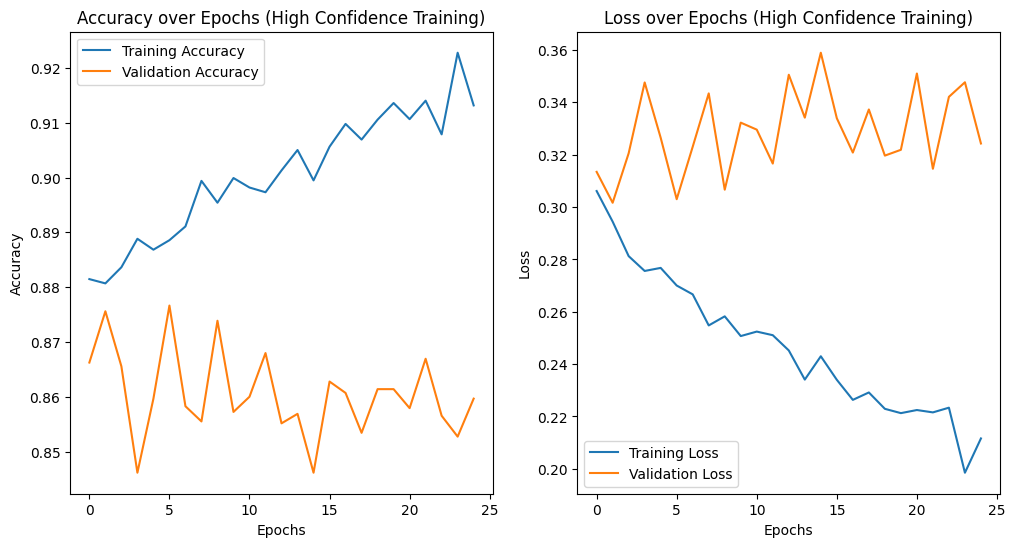

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
import shutil

# Step 1: Function to predict confidence scores for images
def get_predictions(generator, model):
    filenames = generator.filenames
    predictions = model.predict(generator, verbose=1)
    confidence_scores = predictions.max(axis=1)  # Highest confidence score for each image
    predicted_labels = predictions.argmax(axis=1)  # Predicted class for each image
    return filenames, confidence_scores, predicted_labels

# Step 1: Get predictions for the training data
train_generator = datagen.flow_from_directory(
    filtered_image_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False  # Maintain order of images for consistent mapping
)

# Get the filenames and predictions
filenames, confidence_scores, predicted_labels = get_predictions(train_generator, model)

# Step 2: Organize data into a DataFrame for easier handling
train_data = pd.DataFrame({
    'filename': filenames,
    'confidence': confidence_scores,
    'predicted_label': predicted_labels
})

# Map class indices back to their class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}
train_data['predicted_class'] = train_data['predicted_label'].map(class_indices)

# Step 3: Select all high-confidence images per class
selected_images = train_data

# Step 4: Copy selected high-confidence images to a new directory
high_confidence_dir = "high_confidence_images"
os.makedirs(high_confidence_dir, exist_ok=True)

for _, row in tqdm(selected_images.iterrows(), desc="Copying high-confidence images", total=selected_images.shape[0]):
    src_path = os.path.join(filtered_image_dir, row['filename'])
    class_name = row['predicted_class']
    dst_class_dir = os.path.join(high_confidence_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)
    shutil.copy(src_path, dst_class_dir)

# Step 5: Retrain the model with high-confidence images
high_confidence_train_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

high_confidence_val_generator = datagen.flow_from_directory(
    high_confidence_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

print("Classes found:", high_confidence_train_generator.class_indices)
print("Number of training samples:", high_confidence_train_generator.samples)
print("Number of validation samples:", high_confidence_val_generator.samples)

# Retrain the model
history_high_confidence = model.fit(
    high_confidence_train_generator,
    epochs=25,
    validation_data=high_confidence_val_generator
)

# Save the updated model
model.save("lung_disease_model_high_confidence.h5")

# Evaluate model and calculate metrics
val_predictions = model.predict(high_confidence_val_generator)
val_predicted_labels = val_predictions.argmax(axis=1)
true_labels = high_confidence_val_generator.classes

report = classification_report(true_labels, val_predicted_labels, target_names=class_indices.values())
print("\nClassification Report:\n", report)

# Plot accuracy and loss for retraining
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_high_confidence.history['accuracy'], label='Training Accuracy')
plt.plot(history_high_confidence.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_high_confidence.history['loss'], label='Training Loss')
plt.plot(history_high_confidence.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs (High Confidence Training)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()